# Fraud Detection – Task 1: Data Analysis & Preprocessing

## Objective
The goal of this task is to prepare a clean and feature-rich dataset for fraud detection modeling.
This includes:
- Cleaning and validating the data
- Exploring transaction patterns through EDA
- Integrating geolocation data using IP addresses
- Engineering meaningful fraud-related features
- Analyzing and preparing for class imbalance handling

This step is critical to ensure that downstream machine learning models are accurate, robust, and interpretable.


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from datetime import timedelta

sns.set(style="whitegrid")


In [2]:
fraud = pd.read_csv("../data/raw/Fraud_Data.csv")
ip_map = pd.read_csv("../data/raw/IpAddress_to_Country.csv")


In [3]:
fraud.head()
fraud.info()
fraud.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


## 4. Data Cleaning

This section addresses:
- Missing values
- Duplicate records
- Incorrect data types


In [6]:
fraud.isnull().sum()


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [5]:
fraud.duplicated().sum()
fraud.drop_duplicates(inplace=True)


Duplicate transactions can artificially inflate fraud patterns and bias the model.
Therefore, duplicates are removed.


In [7]:
fraud['signup_time'] = pd.to_datetime(fraud['signup_time'])
fraud['purchase_time'] = pd.to_datetime(fraud['purchase_time'])


## 5. Exploratory Data Analysis (EDA)

EDA helps us understand:
- Transaction behavior
- Fraud patterns
- Feature distributions
- Class imbalance severity


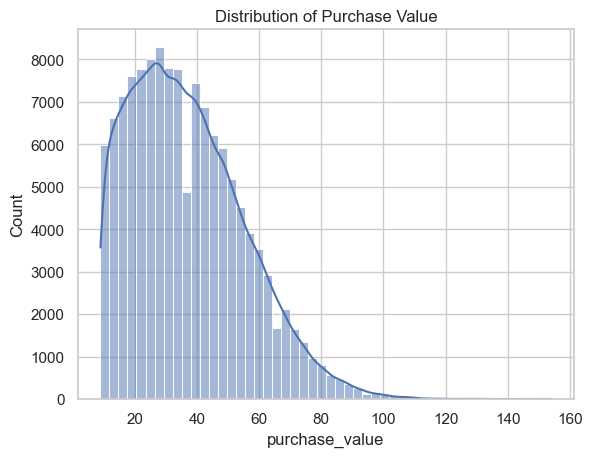

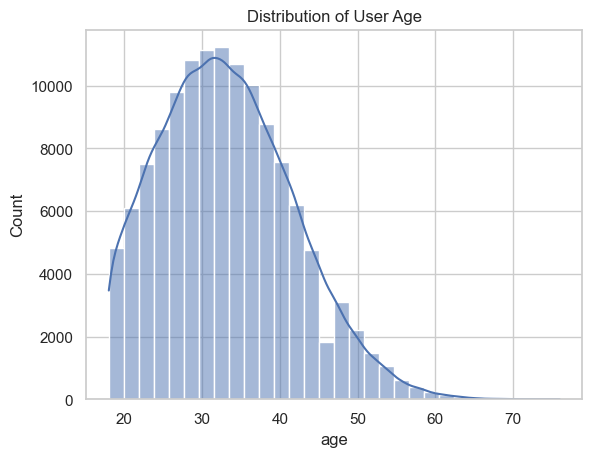

In [36]:
sns.histplot(fraud['purchase_value'], bins=50, kde=True)
plt.title("Distribution of Purchase Value")
plt.show()
sns.histplot(fraud['age'], bins=30, kde=True)
plt.title("Distribution of User Age")
plt.show()


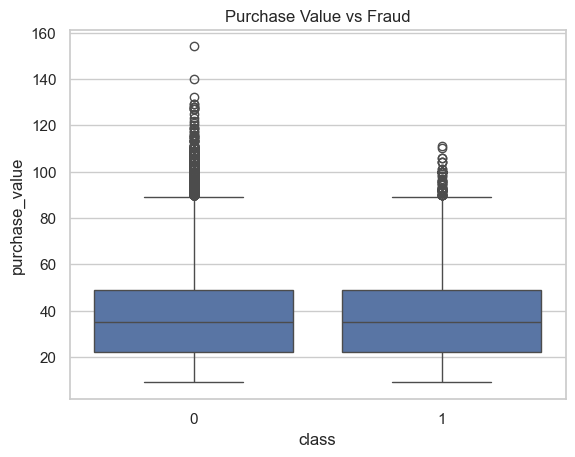

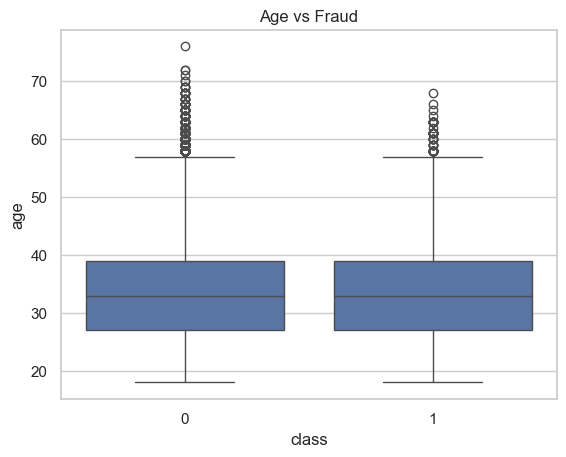

In [37]:
sns.boxplot(x='class', y='purchase_value', data=fraud)
plt.title("Purchase Value vs Fraud")
plt.show()
sns.boxplot(x='class', y='age', data=fraud)
plt.title("Age vs Fraud")
plt.show()


Fraudulent transactions tend to have higher purchase values, indicating higher financial risk.


In [24]:
fraud['class'].value_counts(normalize=True)


class
0    0.905007
1    0.094993
Name: proportion, dtype: float64

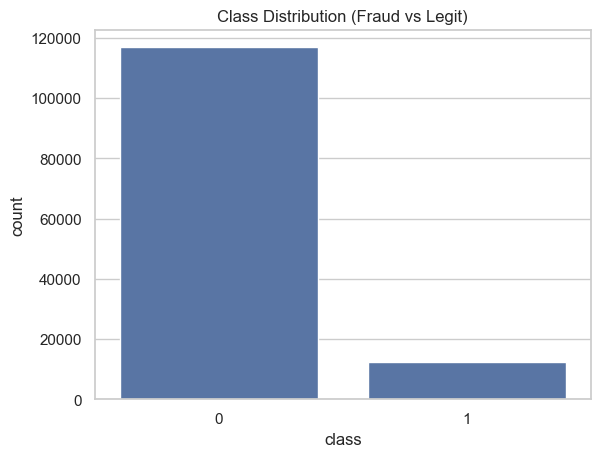

In [25]:
sns.countplot(x='class', data=fraud)
plt.title("Class Distribution (Fraud vs Legit)")
plt.show()


The dataset is highly imbalanced, with fraudulent transactions representing a very small percentage of the data.
This necessitates specialized evaluation metrics and resampling strategies.


In [39]:
fraud['ip_address'] = fraud['ip_address'].astype(int)
ip_map['lower_bound_ip_address'] = ip_map['lower_bound_ip_address'].astype(int)
ip_map['upper_bound_ip_address'] = ip_map['upper_bound_ip_address'].astype(int)


In [40]:
fraud = fraud.sort_values('ip_address')
ip_map = ip_map.sort_values('lower_bound_ip_address')


In [38]:
fraud = pd.merge_asof(
    fraud,
    ip_map,
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'
)

fraud = fraud[fraud['ip_address'] <= fraud['upper_bound_ip_address']]


In [41]:
country_fraud_rate = fraud.groupby('country')['class'].mean().sort_values(ascending=False)
country_fraud_rate.head(10)


country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

Certain countries show disproportionately high fraud rates, suggesting the need for geo-based risk scoring.


In [43]:
fraud['hour_of_day'] = fraud['purchase_time'].dt.hour
fraud['day_of_week'] = fraud['purchase_time'].dt.dayofweek
fraud['time_since_signup'] = (
    fraud['purchase_time'] - fraud['signup_time']
).dt.total_seconds() / 3600


Fraudsters often act quickly after signup and during unusual hours.


In [44]:
fraud['transaction_count'] = fraud.groupby('user_id')['user_id'].transform('count')
fraud.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,hour_of_day,day_of_week,time_since_signup,transaction_count,lower_bound_ip_address_y,upper_bound_ip_address_y,country_y,lower_bound_ip_address,upper_bound_ip_address,country
0,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,SEO,Safari,F,30,16778864,...,3,6,1008.948611,1,16778240,16779263,Australia,16778240,16779263,Australia
1,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,SEO,Chrome,F,34,16842045,...,20,2,342.121389,1,16809984,16842751,Thailand,16809984,16842751,Thailand
2,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,Ads,IE,M,29,16843656,...,23,5,554.870556,1,16843264,16843775,China,16843264,16843775,China
3,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,Direct,Chrome,F,30,16938732,...,16,5,2122.471389,1,16924672,16941055,China,16924672,16941055,China
4,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,SEO,Chrome,F,37,16971984,...,4,1,2847.105278,1,16941056,16973823,Thailand,16941056,16973823,Thailand


In [46]:
from sklearn.preprocessing import StandardScaler

num_cols = ['purchase_value', 'age', 'time_since_signup', 'transaction_count']
scaler = StandardScaler()
fraud[num_cols] = scaler.fit_transform(fraud[num_cols])


In [47]:
fraud = pd.get_dummies(
    fraud,
    columns=['browser', 'source', 'sex', 'country'],
    drop_first=True
)


## Class Imbalance Handling Strategy

Due to extreme imbalance:
- Accuracy is misleading
- Precision-Recall AUC and F1-score are preferred

SMOTE will be applied **only on training data** during modeling to prevent data leakage.


In [48]:
fraud.to_csv("../data/processed/fraud_processed.csv", index=False)
